In [1]:
import tensorflow as tf
import numpy as np
from six.moves import cPickle as pickle
from scipy import ndimage
from PIL import Image
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

## Load Data

In [2]:
with open('SVHN_data.pickle', 'rb') as f:
    tmp = pickle.load(f)
    train_dataset = tmp['train_dataset']
    train_labels = tmp['train_labels']
    valid_dataset = tmp['valid_dataset']
    valid_labels = tmp['valid_labels']
    test_dataset = tmp['test_dataset']
    test_labels = tmp['test_labels']
    del tmp
    
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (26721, 32, 32, 1), (26721, 5))
('Validation set', (6680, 32, 32, 1), (6680, 5))
('Test set', (13068, 32, 32, 1), (13068, 5))


## Final Model

In [3]:
image_size = 32
num_labels = 11  # 0-9, + blank 
num_channels = 1 # grayscale

batch_size = 32
patch_size = 5

depthC1 = 16 
depthC2 = 32 
depthC3 = 64 
depthC4 = 96

depthFC1 = 128
kp = 0.9

graph = tf.Graph()

with graph.as_default():
    # Input data.    
    tf_test_dataset = tf.placeholder(tf.float32, shape=(test_dataset.shape[0], image_size, image_size, num_channels))


    # Variables.
    W_conv1 = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depthC1],stddev=0.1))
    b_conv1 = tf.Variable(tf.ones([depthC1]))
    
    W_conv2 = tf.Variable(tf.truncated_normal([patch_size, patch_size, depthC1, depthC2],stddev=0.1))
    b_conv2 = tf.Variable(tf.ones([depthC2]))
    
    W_conv3 = tf.Variable(tf.truncated_normal([patch_size, patch_size,depthC2, depthC3],stddev=0.1))
    b_conv3 = tf.Variable(tf.ones([depthC3]))
    
    W_conv4 = tf.Variable(tf.truncated_normal([patch_size, patch_size,depthC3, depthC4],stddev=0.1))
    b_conv4 = tf.Variable(tf.ones([depthC4]))

    W_fc1 = tf.Variable(tf.truncated_normal([2*2*depthC4, depthFC1],stddev=0.1))
    b_fc1 = tf.Variable(tf.ones([depthFC1]))
    
    W_o1 = tf.Variable(tf.truncated_normal([depthFC1, num_labels],stddev=0.1))
    b_o1 = tf.Variable(tf.ones([num_labels]))
    
    W_o2 = tf.Variable(tf.truncated_normal([depthFC1, num_labels],stddev=0.1))
    b_o2 = tf.Variable(tf.ones([num_labels]))
    
    W_o3 = tf.Variable(tf.truncated_normal([depthFC1, num_labels],stddev=0.1))
    b_o3 = tf.Variable(tf.ones([num_labels]))
    
    W_o4 = tf.Variable(tf.truncated_normal([depthFC1, num_labels],stddev=0.1))
    b_o4 = tf.Variable(tf.ones([num_labels]))
    
    W_o5 = tf.Variable(tf.truncated_normal([depthFC1, num_labels],stddev=0.1))
    b_o5 = tf.Variable(tf.ones([num_labels]))

  
    # CNN
    def model(data, keep_prob=1):
        #CONV
        h_conv1 = tf.nn.conv2d(data,W_conv1, [1,1,1,1],padding='SAME', name='conv_layer1') + b_conv1  #VALID
        #h_conv1 = tf.contrib.layers.batch_norm(h_conv1, center=True, scale=True, is_training=isTraining)
        h_conv1 = tf.nn.relu(h_conv1)
        h_conv1 = tf.nn.lrn(h_conv1) 
        h_conv1 = tf.nn.max_pool(h_conv1, [1,2,2,1], [1,2,2,1], 'SAME') 
        
        h_conv2 = tf.nn.conv2d(h_conv1, W_conv2, [1,1,1,1], padding='SAME', name='conv_layer2') + b_conv2 #VALID
        #h_conv2 = tf.contrib.layers.batch_norm(h_conv2, center=True, scale=True, is_training=isTraining)
        h_conv2 = tf.nn.relu(h_conv2)
        h_conv2 = tf.nn.lrn(h_conv2) 
        h_conv2 = tf.nn.max_pool(h_conv2, [1,2,2,1], [1,2,2,1], 'SAME')
        
        h_conv3 = tf.nn.conv2d(h_conv2, W_conv3, [1,1,1,1], padding='SAME', name='conv_layer3') + b_conv3 #VALID
        #h_conv3 = tf.contrib.layers.batch_norm(h_conv3, center=True, scale=True, is_training=isTraining)
        h_conv3 = tf.nn.relu(h_conv3)
        h_conv3 = tf.nn.lrn(h_conv3)
        h_conv3 = tf.nn.max_pool(h_conv3, [1,2,2,1], [1,2,2,1], 'SAME')
        
        h_conv4 = tf.nn.conv2d(h_conv3, W_conv4, [1,1,1,1], padding='SAME', name='conv_layer4') + b_conv4 #VALID
        #h_conv4 = tf.contrib.layers.batch_norm(h_conv4, center=True, scale=True, is_training=isTraining)
        h_conv4 = tf.nn.relu(h_conv4)
        h_conv4 = tf.nn.lrn(h_conv4)
        h_conv4 = tf.nn.max_pool(h_conv4, [1,2,2,1], [1,2,2,1], 'SAME')
        
        h_conv4 = tf.nn.dropout(h_conv4, keep_prob)
        
        #Reshape
        shape = h_conv4.get_shape().as_list()
        h_conv4 = tf.reshape(h_conv4, [shape[0], shape[1] * shape[2] * shape[3]])
        
        #FC
        h_fc1 = tf.matmul(h_conv4, W_fc1) + b_fc1
        h_fc1 = tf.nn.relu(h_fc1)
        h_fc1 = tf.nn.dropout(h_fc1, keep_prob)

        #OUTPUT
        logits1 = tf.matmul(h_fc1, W_o1) + b_o1
        logits2 = tf.matmul(h_fc1, W_o2) + b_o2
        logits3 = tf.matmul(h_fc1, W_o3) + b_o3
        logits4 = tf.matmul(h_fc1, W_o4) + b_o4
        logits5 = tf.matmul(h_fc1, W_o5) + b_o5
        return tf.pack([logits1, logits2, logits3, logits4, logits5])
  
    test_prediction =  tf.transpose(tf.argmax(model(tf_test_dataset), axis = 2))
    saver = tf.train.Saver()

In [4]:
with tf.Session(graph=graph) as sess:
    saver.restore(sess, "./ckpt_folder/CNN_trained_finalModel.ckpt-20000")
    test_prediction = sess.run(test_prediction, feed_dict={tf_test_dataset : test_dataset})

## Predictions of sample images from the testing dataset

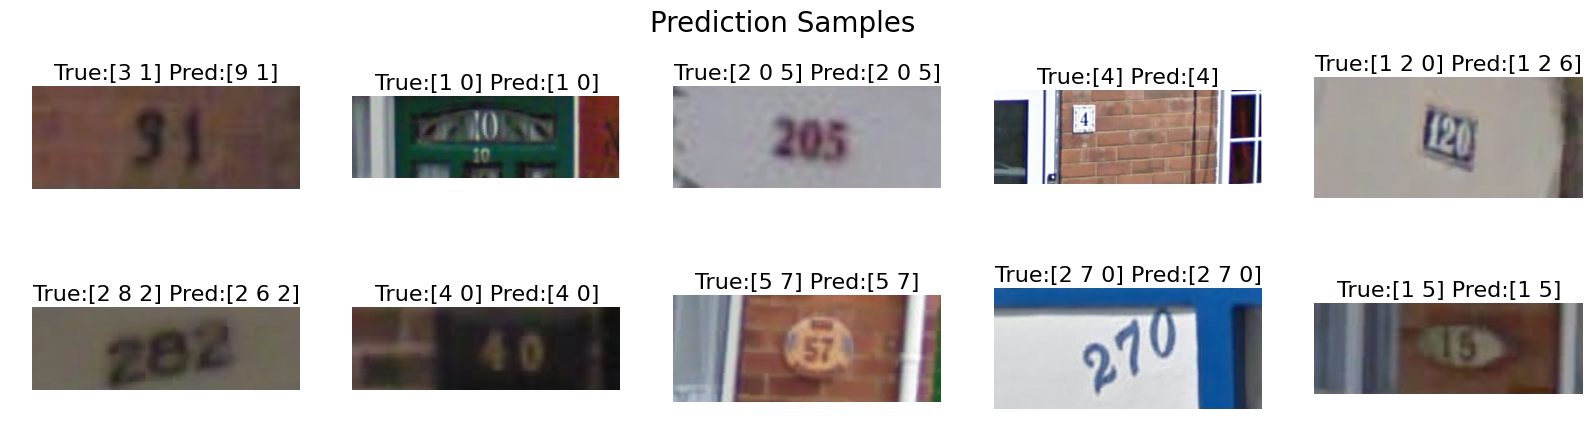

In [31]:
fig = plt.figure(figsize=(20,5)) 
fig.suptitle('Prediction Samples',fontsize=20)
gs = gridspec.GridSpec(2,5)

test_sample = np.sort(np.random.randint(0, test_labels.shape[0], size=10))
   
for i in range(test_sample.shape[0]):
    sampleIdx = test_sample[i]
    im = Image.open(os.path.join('test', str(sampleIdx+1)+'.png'))
    house_num = ''
    trueDigits = test_labels[sampleIdx, :][test_labels[sampleIdx, :] < 10].astype(int)
    predDigits = test_prediction[sampleIdx, :][test_prediction[sampleIdx, :] < 10].astype(int) 
    ax = plt.subplot(gs[i/5,i%5])
    ax.axis('off')
    ax.set_title('True:'+str(trueDigits)+ ' Pred:'+str(predDigits), loc='center', fontsize=16)
    ax.imshow(im)
plt.savefig('./imgs/Prediction_samples.png')
plt.show()